# Dependências 

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from glob import glob
from os.path import basename
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, LSTM, Dropout, Embedding
from keras.models import Sequential

pd.options.display.max_columns = None
%matplotlib inline

Using TensorFlow backend.


In [2]:
COLS_SCOUTS_DEF = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
COLS_SCOUTS_ATK = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
COLS_SCOUTS = COLS_SCOUTS_DEF + COLS_SCOUTS_ATK
SCOUTS_POINTS = np.array([-2.0, -5.0,  3.0, 7.0, -0.5, -5.0, -2.0, 1.5, 5.0, 
                          5.0, 1.2, 0.8, 0.5, 3.0, 8.0, -0.5, -0.3, -4.0])

COLS_STATISTICS = ['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num', 'atletas.media_num']
COLS_ATHLETES_INFO = ['atletas.atleta_id', 'atletas.apelido', 'atletas.posicao_id', 'atletas.clube.id.full.name', 'atletas.status_id']

COL_ID = 'atletas.atleta_id'
COL_ROUND = 'atletas.rodada_id'
COL_POINTS = 'atletas.pontos_num'
COL_POSITION = 'atletas.posicao_id'
COL_STATUS = 'atletas.status_id'
COL_TEAM_ID = 'atletas.clube.id.full.name'
COL_NICKNAME = 'atletas.apelido'

COLS_ALL = [COL_ROUND] + COLS_ATHLETES_INFO + COLS_STATISTICS + COLS_SCOUTS

In [3]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.hdf5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return '{}{}{}{}'.format(prefix, timestamp, suffix, ext)

# Importação dos Dados

In [4]:
def import_data(folder_year):
    list_files = glob(folder_year + 'rodada-*.csv')
    df_data = pd.DataFrame([])
    
    for file in list_files:
        df_round = pd.read_csv(file, index_col=0)
        print('Importando {} linhas do arquivo {}'.format(df_round.shape[0], basename(file)))
        df_data = df_data.append(df_round, sort=False)
    return df_data

In [5]:
df = import_data('../../data/2019/')
df = df[COLS_ALL]
df.reset_index(drop=True, inplace=True)
print(df.shape)

df.describe()

Importando 740 linhas do arquivo rodada-1.csv
Importando 792 linhas do arquivo rodada-10.csv
Importando 804 linhas do arquivo rodada-11.csv
Importando 805 linhas do arquivo rodada-12.csv
Importando 810 linhas do arquivo rodada-13.csv
Importando 810 linhas do arquivo rodada-14.csv
Importando 807 linhas do arquivo rodada-15.csv
Importando 804 linhas do arquivo rodada-16.csv
Importando 738 linhas do arquivo rodada-2.csv
Importando 739 linhas do arquivo rodada-3.csv
Importando 739 linhas do arquivo rodada-4.csv
Importando 771 linhas do arquivo rodada-5.csv
Importando 766 linhas do arquivo rodada-6.csv
Importando 770 linhas do arquivo rodada-7.csv
Importando 769 linhas do arquivo rodada-8.csv
Importando 775 linhas do arquivo rodada-9.csv
(12439, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,12439.000000,12439.000000,12439.000000,12439.000000,12439.000000,12439.000000,3237.000000,246.000000,489.000000,60.000000,5942.000000,63.000000,498.000000,5707.000000,1776.00000,1399.000000,3584.000000,4379.000000,6021.000000,626.000000,1776.000000,1648.000000,6537.000000,93.0
mean,8.651821,83238.598521,1.110368,5.004733,0.000371,1.605430,1.677788,1.052846,9.300613,1.150000,5.928307,1.190476,6.391566,6.304714,2.18018,1.318799,2.515067,3.128797,5.480319,1.143770,1.615991,1.873180,9.108307,1.0
std,4.599082,19010.984834,2.905495,3.733548,0.838527,2.326687,0.941249,0.224181,7.718247,0.360085,5.183836,0.395831,4.863663,5.983871,1.41468,0.625985,2.010938,2.707002,5.348905,0.351137,1.204243,1.508224,8.196852,0.0
min,1.000000,36886.000000,-9.300000,0.690000,-9.310000,-9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
25%,5.000000,71709.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,4.000000,1.000000,2.000000,1.000000,3.000000,2.000000,1.00000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.0
50%,9.000000,86932.000000,0.000000,4.000000,0.000000,0.600000,1.000000,1.000000,7.000000,1.000000,4.000000,1.000000,5.000000,4.000000,2.00000,1.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000,7.000000,1.0
75%,13.000000,99574.000000,0.700000,6.730000,0.000000,2.970000,2.000000,1.000000,13.000000,1.000000,8.000000,1.000000,9.000000,9.000000,3.00000,1.500000,3.000000,4.000000,8.000000,1.000000,2.000000,2.000000,12.000000,1.0
max,16.000000,106083.000000,37.700000,23.620000,14.520000,22.700000,7.000000,2.000000,40.000000,2.000000,40.000000,2.000000,27.000000,42.000000,8.00000,6.000000,15.000000,24.000000,42.000000,2.000000,12.000000,11.000000,57.000000,1.0


# Limpeza dos Dados 

In [6]:
def decumulate_scouts(df):
    list_ids = list(df[COL_ID].unique())
    n_players = len(list_ids)

    df_copy = df.copy()
    for i, player_id in enumerate(list_ids):
        print('{} of {}'.format(i + 1, n_players), end='\r')

        df_player = df[df[COL_ID] == player_id].sort_values(by=COL_ROUND)
        df_shift = df_player.shift(fill_value=0.0)
        df_player[COLS_SCOUTS] = df_player[COLS_SCOUTS] - df_shift[COLS_SCOUTS]

        df_copy.loc[df_player.index] = df_player

    return df_copy

def check_scouts_pontuation(df):
    df_copy = df.copy()
    df_copy['computed'] = df_copy.apply(lambda row: np.round(sum(row[COLS_SCOUTS] * SCOUTS_POINTS), decimals=2), axis=1)
    mask_diff = df_copy[COL_POINTS] != df_copy['computed']
    display(df_copy[mask_diff])

In [7]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=COLS_SCOUTS)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove técnicos
df_clean = df_clean[df_clean[COL_POSITION] != "tec"]
print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# altera os Status == 'Nulo' para 'Provável'
df_clean.loc[df_clean[COL_STATUS] == 'Nulo', COL_STATUS] = 'Provável'

# preenche scouts NANs com zero
df_clean[COLS_SCOUTS] = df_clean[COLS_SCOUTS].fillna(value=0)

# desacumula os valores de scouts
df_clean = decumulate_scouts(df_clean)

# checa se...
assert(~df_clean.isnull().any().any()) # ainda existem valores nulos
assert((df_clean[COLS_SCOUTS].min() >= 0.0).all()) # há scouts negativos

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)
df_clean.describe()

Dimensões originais dos dados:  (12439, 28)
qtde. de jogadores com scouts:  7253
qtde. de linhas com posições válidas:  7253
Dimensão dos dados após as limpezas:  (7253, 28)


,atletas.rodada_id,atletas.atleta_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP
count,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000,7253.000000
mean,9.308010,78320.497036,1.747884,6.229799,0.000121,2.593081,0.091962,0.005239,0.074314,0.001241,0.605129,0.001241,0.050738,0.602647,0.067834,0.031022,0.154557,0.231490,0.564042,0.011719,0.047980,0.055977,0.996829,0.001517
std,4.432585,18973.604254,3.576708,3.892977,1.083811,2.514895,0.288992,0.072198,0.462455,0.038927,1.034371,0.035206,0.333654,1.083193,0.251478,0.183436,0.452020,0.568323,1.023813,0.107627,0.232881,0.272694,1.474219,0.038917
min,1.000000,37604.000000,-9.300000,0.690000,-9.310000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,68930.000000,0.000000,3.470000,-0.270000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,81241.000000,0.000000,5.280000,0.000000,2.350000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.000000,93791.000000,2.700000,8.150000,0.080000,3.930000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,16.000000,105913.000000,37.700000,23.620000,14.520000,22.700000,1.000000,1.000000,7.000000,2.000000,9.000000,1.000000,6.000000,8.000000,1.000000,2.000000,4.000000,5.000000,8.000000,1.000000,3.000000,4.000000,10.000000,1.000000


In [8]:
check_scouts_pontuation(df_clean)

,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.posicao_id,atletas.clube.id.full.name,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP,computed
3768,13,97527,Matheus Alessandro,ata,Fortaleza,Provável,0.0,2.58,0.0,1.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.5


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [254 313 366 395 418 438 453 468 465 493 509 521 527 539 547 547]


<BarContainer object of 16 artists>

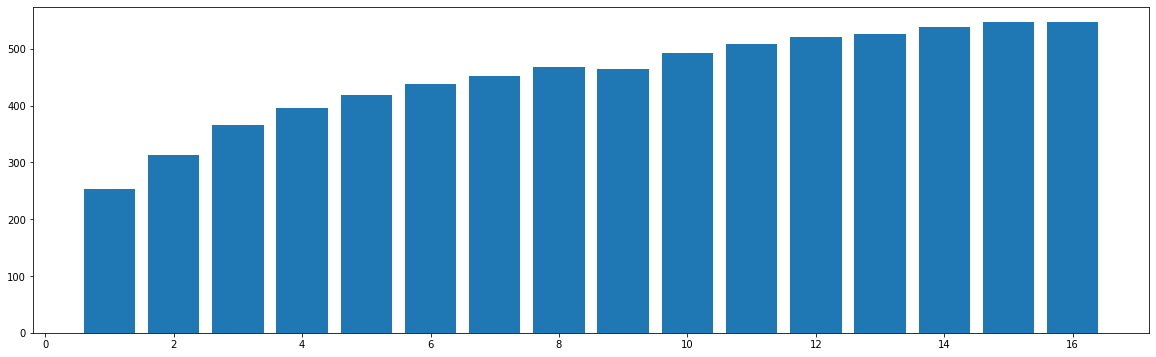

In [9]:
unique, counts = np.unique(df_clean[COL_ROUND].values, return_counts=True)
print(unique, counts)

plt.figure(figsize=(20, 6))
plt.bar(unique, counts)

In [10]:
pandas_profiling.ProfileReport(df_clean)

C:\Users\Arnaldo\AppData\Local\Continuum\miniconda3\envs\deeplearning-gpu\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,29
Number of observations,7253
Total Missing (%),0.0%
Total size in memory,1.6 MiB
Average record size in memory,232.0 B
Numeric,19
Categorical,4
Boolean,6
Date,0
Text (Unique),0
Rejected,0


# Criação das Amostras

In [9]:
def create_samples(df, cols_of_interest, from_round=1, to_round=None, last_rounds=None, return_pred=True):
    players = list(df[COL_ID].unique())
    rounds = list(df[COL_ROUND].unique())
    n_rounds = max(rounds)
    n_players = len(players)
    to_round = n_rounds if to_round is None else to_round
    last_rounds = n_rounds - 1 if last_rounds is None else last_rounds
    
    list_rounds = np.array([list(range(1, n_rounds+1))  for _ in range(n_players)]).flatten()
    list_players = np.array([[player] * n_rounds for player in players]).flatten()
    df_all = pd.DataFrame([[p, r] for p, r in zip(list_players, list_rounds)], columns=[COL_ID, COL_ROUND])
    
    df_merge = df_all.merge(df, how='left', on=[COL_ID, COL_ROUND])
    df_merge.fillna(value=0, inplace=True)
    
    x, y = [], []
    for r in range(from_round, to_round - last_rounds + 1):
        print('x: rodadas de {:}-{:} y: rodada {}'.format(r, r + last_rounds - 1, r + last_rounds))
        
        df_round = df_merge[(df_merge[COL_ROUND] >= r) & (df_merge[COL_ROUND] < r + last_rounds)]
        df_group = df_round.groupby(by=[COL_ID], as_index=False, sort=False)
        x.append([data[cols_of_interest].values for _, data in df_group])
            
        df_ids = pd.DataFrame([data[COL_ID].values[0] for _, data in df_group], columns=[COL_ID])
        if return_pred:
            df_next = df_merge[df_merge[COL_ROUND] == r + last_rounds]
            assert(np.all(df_ids[COL_ID].values ==  df_next[COL_ID].values))

            df_points = df_ids.merge(df_next, how='left', on=[COL_ID])[COL_POINTS]
            y.append(df_points.fillna(value=0).values)
        
    return np.concatenate([r for r in x]), np.array(y).flatten() if return_pred else df_ids[COL_ID].values

In [10]:
df_samples = pd.get_dummies(df_clean, columns=[COL_POSITION, COL_TEAM_ID], prefix=['pos', 'clube'])
print(df_samples.shape)
df_samples.head()

(6706, 51)


,atletas.rodada_id,atletas.atleta_id,atletas.apelido,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,CA,CV,DD,DP,FC,GC,GS,RB,SG,A,FD,FF,FS,FT,G,I,PE,PP,pos_ata,pos_gol,pos_lat,pos_mei,pos_zag,clube_Athlético-PR,clube_Atlético-MG,clube_Avaí,clube_Bahia,clube_Botafogo,clube_CSA,clube_Ceará,clube_Chapecoense,clube_Corinthians,clube_Cruzeiro,clube_Flamengo,clube_Fluminense,clube_Fortaleza,clube_Goiás,clube_Grêmio,clube_Internacional,clube_Palmeiras,clube_Santos,clube_São Paulo,clube_Vasco
1,1,80196,Yago Pikachu,Provável,2.0,11.10,-2.90,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,1,78445,Renê,Provável,0.6,8.74,-3.26,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,1,80853,Pedro Geromel,Provável,8.0,12.49,2.49,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
10,1,38229,Fábio Santos,Provável,9.4,12.77,3.77,9.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,0.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1,38910,Ricardo Oliveira,Provável,12.3,18.94,3.94,12.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
cols_of_interest = df_samples.columns.drop([COL_ROUND, COL_ID, COL_NICKNAME, COL_STATUS])
cols_of_interest

Index(['atletas.pontos_num', 'atletas.preco_num', 'atletas.variacao_num',
       'atletas.media_num', 'CA', 'CV', 'DD', 'DP', 'FC', 'GC', 'GS', 'RB',
       'SG', 'A', 'FD', 'FF', 'FS', 'FT', 'G', 'I', 'PE', 'PP', 'pos_ata',
       'pos_gol', 'pos_lat', 'pos_mei', 'pos_zag', 'clube_Athlético-PR',
       'clube_Atlético-MG', 'clube_Avaí', 'clube_Bahia', 'clube_Botafogo',
       'clube_CSA', 'clube_Ceará', 'clube_Chapecoense', 'clube_Corinthians',
       'clube_Cruzeiro', 'clube_Flamengo', 'clube_Fluminense',
       'clube_Fortaleza', 'clube_Goiás', 'clube_Grêmio', 'clube_Internacional',
       'clube_Palmeiras', 'clube_Santos', 'clube_São Paulo', 'clube_Vasco'],
      dtype='object')

In [20]:
x, y = create_samples(df_samples, cols_of_interest, from_round=1, to_round=15, last_rounds=5)

print(x.shape, y.shape)

x: rodadas de 1-5 y: rodada 6
x: rodadas de 2-6 y: rodada 7
x: rodadas de 3-7 y: rodada 8
x: rodadas de 4-8 y: rodada 9
x: rodadas de 5-9 y: rodada 10
x: rodadas de 6-10 y: rodada 11
x: rodadas de 7-11 y: rodada 12
x: rodadas de 8-12 y: rodada 13
x: rodadas de 9-13 y: rodada 14
x: rodadas de 10-14 y: rodada 15
(5900, 5, 47) (5900,)


# Treinamento do Modelo

In [28]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=x.shape[1:]))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

FILE_MODEL = 'models/' + timestamp_model_name()
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, verbose=1, save_best_only=True),
    EarlyStopping(verbose=1, patience=20)
]

hist = model.fit(x, y, batch_size=32, epochs=200, validation_split=0.2, callbacks=list_callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 32)             10240     
_________________________________________________________________
lstm_26 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 22,785
Trainable params: 22,785
Non-trainable params: 0
_________________________________________________________________
Train 

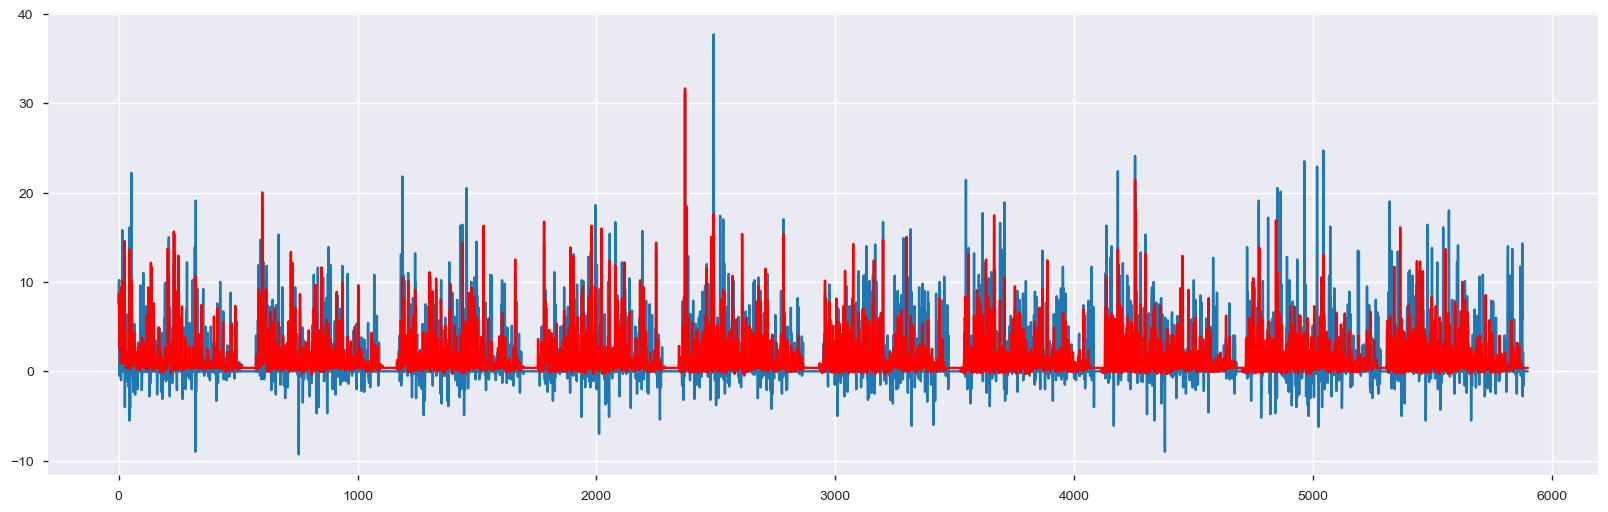

In [29]:
y_pred = model.predict(x)

plt.figure(figsize=(20, 6))
plt.plot(y)
plt.plot(y_pred, color='red')

# Predição de Jogadores

In [ ]:
x_test, ids = create_samples(df_samples, cols_of_interest, from_round=2, to_round=5, last_rounds=3, return_pred=False)

print(x_test.shape, ids.shape)

In [ ]:
y_next = model.predict(x_test)
sort_pos = np.argsort(y_next.flatten())
best_ids = ids[sort_pos[-10:]]

print(best_ids)

In [ ]:
assert(np.all(df_samples[COL_ID].values == df_clean[COL_ID].values))

df_pred = df_clean[df_clean[COL_ID].isin(best_ids)].drop_duplicates(subset=COL_ID)
df_pred

In [ ]:
y_next[sort_pos[-10:]]